# Uber NYC 2015 – Data Analysis Project  
### End-to-End Exploratory Data Analysis  
**Author:** Linda Mthembu  
**Tools:** Python (pandas, numpy, seaborn, matplotlib, plotly, folium)

## Project Overview

This project analyses Uber trip data from New York City (2014–2015).  
The goal is to understand:

- Demand patterns (hourly, daily, monthly)
- Busiest pickup days
- Peak hours
- Geographic hotspots
- Fleet utilisation patterns
- Dispatch base activity

The project follows the full Data Analysis Lifecycle:
1. Data Collection  
2. Data Cleaning  
3. Feature Engineering  
4. Exploratory Data Analysis (EDA)  
5. Visualisation (static + interactive)  
6. Insights & Recommendations  


In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import folium
from folium.plugins import HeatMap

# ------------------------------------------------------------------
# Paths
# Notebook lives in:  .../Uber-NYC-2015-Analysis/notebooks
# Project root is:    .../Uber-NYC-2015-Analysis
# Data folder is:     .../Uber-NYC-2015-Analysis/data
# ------------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

print("Using DATA_DIR:", DATA_DIR)
assert DATA_DIR.is_dir(), "DATA_DIR does not exist – check your folder structure."


Using DATA_DIR: c:\Users\LindaMthembu\OneDrive - iqbusiness (Pty) Ltd\Documents\Data Analysis Projects\Uber\Uber-NYC-2015-Analysis\data


In [2]:
# 1. Load Dataset (Jan–Jun 2015 sample)

uber_15 = pd.read_csv(DATA_DIR / "uber-raw-data-janjune-15_sample.csv")
print("uber_15 shape:", uber_15.shape)

# 2. Data Cleaning & Preprocessing

# remove duplicates
print("Duplicates before:", uber_15.duplicated().sum())
uber_15.drop_duplicates(inplace=True)
print("Duplicates after:", uber_15.duplicated().sum())

# dtypes and missing values
display(uber_15.dtypes)
display(uber_15.isnull().sum())

# Convert Pickup Date to Datetime
uber_15["Pickup_date"] = pd.to_datetime(uber_15["Pickup_date"])
print("Pickup_date dtype:", uber_15["Pickup_date"].dtype)

# 3. Feature Engineering

uber_15["month"] = uber_15["Pickup_date"].dt.month_name()
uber_15["weekday"] = uber_15["Pickup_date"].dt.day_name()
uber_15["day"] = uber_15["Pickup_date"].dt.day
uber_15["hour"] = uber_15["Pickup_date"].dt.hour
uber_15["minute"] = uber_15["Pickup_date"].dt.minute

uber_15.head()


uber_15 shape: (100000, 4)
Duplicates before: 54
Duplicates after: 0


Dispatching_base_num    object
Pickup_date             object
Affiliated_base_num     object
locationID               int64
dtype: object

Dispatching_base_num       0
Pickup_date                0
Affiliated_base_num     1116
locationID                 0
dtype: int64

Pickup_date dtype: datetime64[ns]


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,month,weekday,day,hour,minute
0,B02617,2015-05-02 21:43:00,B02764,237,May,Saturday,2,21,43
1,B02682,2015-01-20 19:52:59,B02682,231,January,Tuesday,20,19,52
2,B02617,2015-03-19 20:26:00,B02617,161,March,Thursday,19,20,26
3,B02764,2015-04-10 17:38:00,B02764,107,April,Friday,10,17,38
4,B02764,2015-03-23 07:03:00,B00111,140,March,Monday,23,7,3


## 1. Load Dataset

We load the January–June 2015 Uber trip sample dataset.  
The original dataset contains over **15 million records**, but for performance reasons  
we use a curated sample file containing - 1 million rows.

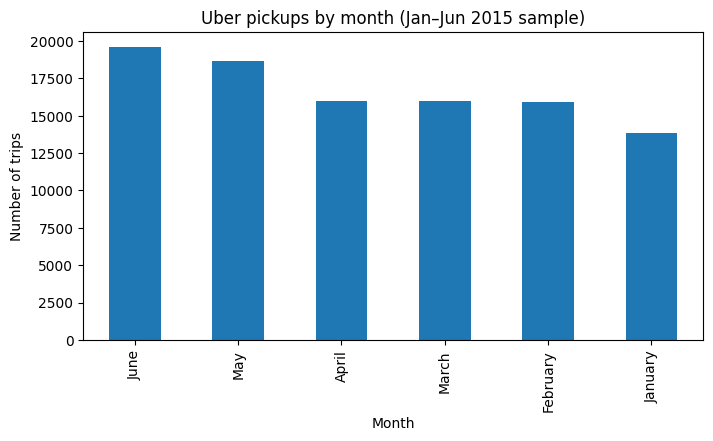

In [3]:
# 4. Monthly Ride Demand

uber_15["month"].value_counts().plot(kind="bar", figsize=(8, 4))
plt.title("Uber pickups by month (Jan–Jun 2015 sample)")
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.show()


weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,2365,1833,2508,2052,2823,1880,2521
February,2655,1970,2550,2183,2396,2129,2013
January,2508,1353,2745,1651,2378,1444,1740
June,2793,2848,3037,2485,2767,3187,2503
March,2465,2115,2522,2379,2093,2388,2007
May,3262,1865,3519,2944,2627,2115,2328


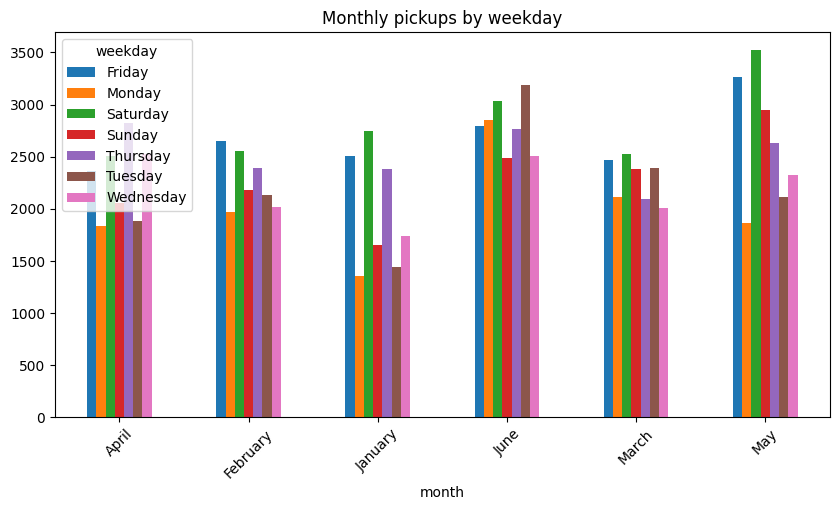

In [4]:
# 5. Month vs Weekday Activity

pivot_month_wd = pd.crosstab(uber_15["month"], uber_15["weekday"])
display(pivot_month_wd)

pivot_month_wd.plot(kind="bar", figsize=(10, 5))
plt.title("Monthly pickups by weekday")
plt.xticks(rotation=45)
plt.show()


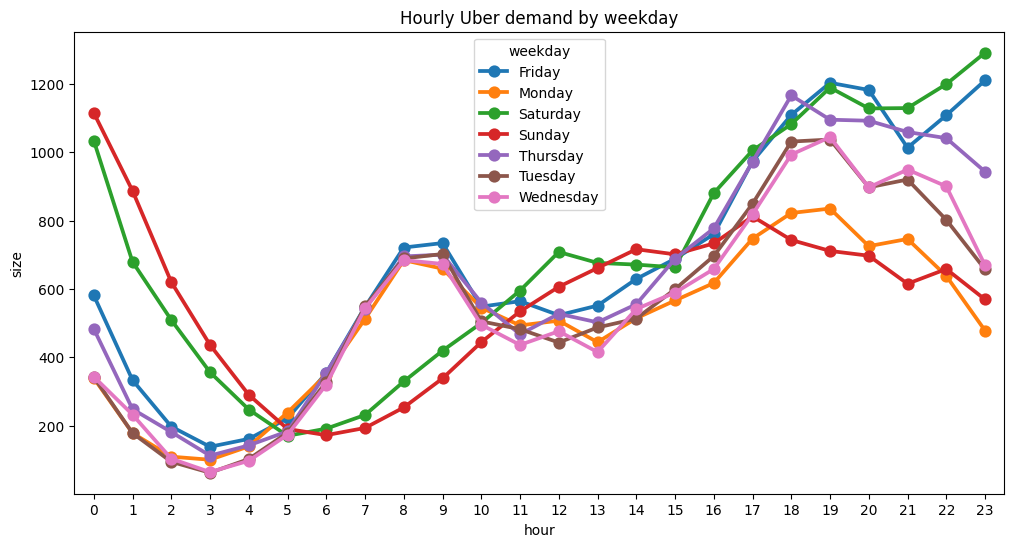

In [5]:
# 6. Hourly Ride Demand by Weekday

summary_wd_hr = uber_15.groupby(["weekday", "hour"], as_index=False).size()

plt.figure(figsize=(12, 6))
sns.pointplot(x="hour", y="size", hue="weekday", data=summary_wd_hr)
plt.title("Hourly Uber demand by weekday")
plt.show()


In [6]:
# 7. Base vs Active Vehicles (FOIL Dataset)

uber_foil = pd.read_csv(DATA_DIR / "Uber-Jan-Feb-FOIL.csv")
uber_foil.head()

pio.renderers.default = "browser"

px.box(
    uber_foil,
    x="dispatching_base_number",
    y="active_vehicles",
    title="Active Vehicles by Dispatch Base",
).show()

px.violin(
    uber_foil,
    x="dispatching_base_number",
    y="active_vehicles",
    title="Distribution of Active Vehicles by Base",
    box=True,
).show()


In [7]:
# 8. Combine All Monthly Uber 2014 Files Into One Dataset
#    and export a 200k sample to data/uber-raw-data.csv for the Streamlit app

from pathlib import Path

# We only want the classic 2014 NYC trip files:
#   uber-raw-data-apr14.csv, ... , uber-raw-data-sep14.csv
raw_files = sorted(
    f
    for f in DATA_DIR.glob("uber-raw-data-*.csv")
    if "janjune-15" not in f.name          # skip the 2015 sample
    and f.name != "uber-raw-data.csv"      # skip the app export file
)

print("\nRaw 2014 files found:")
for f in raw_files:
    print("  -", f.name)

if not raw_files:
    raise FileNotFoundError("No raw 2014 CSV files found in data/.")

# Load & combine
final = pd.DataFrame()

for f in raw_files:
    print(f"Loading: {f.name} ...")
    try:
        df_tmp = pd.read_csv(
            f,
            encoding="latin1",
            engine="python",
            on_bad_lines="skip",
        )
        print(f"  ✓ Loaded {df_tmp.shape[0]} rows")
        final = pd.concat([final, df_tmp], ignore_index=True)
    except Exception as e:
        print(f"  ✗ Skipped {f.name} due to error: {e}")

print("\nFinal combined dataset shape:", final.shape)
display(final.head())

if final.empty:
    raise ValueError("Combined dataset is empty – something is wrong with the input files.")

# Take a 200k sample (or all rows if fewer)
sample_size = min(200_000, len(final))
print("Sample size to export:", sample_size)

final_sample = final.sample(sample_size, random_state=42)
print("Sampled dataset shape:", final_sample.shape)

# Save to file used by the Streamlit app
export_path = DATA_DIR / "uber-raw-data.csv"
final_sample.to_csv(export_path, index=False)

print(f"\n✅ Saved sampled file for the app to: {export_path}")



Raw 2014 files found:
  - uber-raw-data-apr14.csv
  - uber-raw-data-aug14.csv
  - uber-raw-data-jul14.csv
  - uber-raw-data-jun14.csv
  - uber-raw-data-may14.csv
  - uber-raw-data-sep14.csv
Loading: uber-raw-data-apr14.csv ...
  ✓ Loaded 564516 rows
Loading: uber-raw-data-aug14.csv ...
  ✓ Loaded 829275 rows
Loading: uber-raw-data-jul14.csv ...
  ✓ Loaded 796121 rows
Loading: uber-raw-data-jun14.csv ...
  ✓ Loaded 663844 rows
Loading: uber-raw-data-may14.csv ...
  ✓ Loaded 652435 rows
Loading: uber-raw-data-sep14.csv ...
  ✓ Loaded 1028136 rows

Final combined dataset shape: (4534327, 4)


,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


Sample size to export: 200000
Sampled dataset shape: (200000, 4)

✅ Saved sampled file for the app to: c:\Users\LindaMthembu\OneDrive - iqbusiness (Pty) Ltd\Documents\Data Analysis Projects\Uber\Uber-NYC-2015-Analysis\data\uber-raw-data.csv


In [8]:
# 9. NYC Hotspot Map (Geospatial Analysis) - using `final` from the previous cell

# Try to normalise coordinate column names
coord_cols = [c for c in final.columns if "lat" in c.lower() or "lon" in c.lower()]
print("Coordinate-like columns:", coord_cols)

# Rename first lat / lon-ish columns to Lat / Lon if needed
if "Lat" not in final.columns:
    lat_candidates = [c for c in final.columns if "lat" in c.lower()]
    if lat_candidates:
        final = final.rename(columns={lat_candidates[0]: "Lat"})

if "Lon" not in final.columns:
    lon_candidates = [c for c in final.columns if "lon" in c.lower()]
    if lon_candidates:
        final = final.rename(columns={lon_candidates[0]: "Lon"})

if {"Lat", "Lon"}.issubset(final.columns):
    geo = final.dropna(subset=["Lat", "Lon"])
    print("Rows with valid Lat/Lon:", len(geo))

    basemap = folium.Map(location=[40.75, -73.97], zoom_start=12)

    rush_uber = geo.groupby(["Lat", "Lon"], as_index=False).size()
    HeatMap(rush_uber[["Lat", "Lon", "size"]].values).add_to(basemap)
    basemap
else:
    print("No Lat/Lon columns available for hotspot map.")


Coordinate-like columns: ['Lat', 'Lon']
Rows with valid Lat/Lon: 4534327


In [9]:
# 10. Hour vs Day Pairwise Analysis (on `final`)

# Ensure we have a usable datetime column
if "Date/Time" in final.columns:
    dt_col = "Date/Time"
elif "Date" in final.columns:
    dt_col = "Date"
else:
    raise KeyError("No suitable datetime column found in `final`.")

final[dt_col] = pd.to_datetime(final[dt_col])
final["day"] = final[dt_col].dt.day
final["hour"] = final[dt_col].dt.hour

pivot_day_hour = final.groupby(["day", "hour"]).size().unstack()
pivot_day_hour.style.background_gradient(cmap="viridis")


hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
1,3247,1982,1284,1331,1458,2171,3717,5470,5376,4688,4680,4811,5018,5887,7050,8033,8760,9661,8727,8146,7448,7960,6397,4128
2,2480,1600,1109,1442,1897,2861,5002,6646,6420,4795,4886,5067,5278,5801,7021,8581,10267,11301,11326,9654,8903,8506,7111,5247
3,3415,2176,1434,1489,1578,2437,4318,5775,5482,4732,4864,5162,5462,6189,7327,8991,10472,10665,11433,9765,9158,8646,7246,4767
4,2944,1718,1217,1449,1737,2623,4687,6146,5799,4814,4822,5067,5289,6273,7307,8678,9661,10550,10458,9296,8508,8804,7852,5224
5,2786,1567,1047,1278,1648,2958,4919,6379,6580,5616,5225,5097,5129,5780,7072,8453,9770,10887,10324,9582,9512,9785,9020,6640
6,4623,2932,1902,1599,1584,2201,3705,4846,5009,4482,4891,5264,5528,6378,7353,8751,9615,10130,9437,8575,8286,8734,8000,6061
7,3715,2326,1533,1622,1793,2464,4172,5649,5459,4706,4982,5266,5455,6315,7418,8624,10585,11185,10767,9674,8862,8692,7337,4902
8,2882,1672,1147,1509,1921,3282,5528,7474,7472,5770,5368,5433,5576,6424,7356,8910,10007,10871,9874,8964,8768,8528,6917,4331
9,2708,1757,1246,1501,1911,3227,5910,7720,7641,5983,5500,5542,5607,6540,7997,9360,10419,12116,11677,9979,9061,8806,7637,5290


In [10]:
# 11. Automate Pivot Table Creation

def gen_pivot_table(df, col1, col2):
    pivot = df.groupby([col1, col2]).size().unstack()
    return pivot.style.background_gradient(cmap="viridis")

gen_pivot_table(final, "day", "hour")


hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
1,3247,1982,1284,1331,1458,2171,3717,5470,5376,4688,4680,4811,5018,5887,7050,8033,8760,9661,8727,8146,7448,7960,6397,4128
2,2480,1600,1109,1442,1897,2861,5002,6646,6420,4795,4886,5067,5278,5801,7021,8581,10267,11301,11326,9654,8903,8506,7111,5247
3,3415,2176,1434,1489,1578,2437,4318,5775,5482,4732,4864,5162,5462,6189,7327,8991,10472,10665,11433,9765,9158,8646,7246,4767
4,2944,1718,1217,1449,1737,2623,4687,6146,5799,4814,4822,5067,5289,6273,7307,8678,9661,10550,10458,9296,8508,8804,7852,5224
5,2786,1567,1047,1278,1648,2958,4919,6379,6580,5616,5225,5097,5129,5780,7072,8453,9770,10887,10324,9582,9512,9785,9020,6640
6,4623,2932,1902,1599,1584,2201,3705,4846,5009,4482,4891,5264,5528,6378,7353,8751,9615,10130,9437,8575,8286,8734,8000,6061
7,3715,2326,1533,1622,1793,2464,4172,5649,5459,4706,4982,5266,5455,6315,7418,8624,10585,11185,10767,9674,8862,8692,7337,4902
8,2882,1672,1147,1509,1921,3282,5528,7474,7472,5770,5368,5433,5576,6424,7356,8910,10007,10871,9874,8964,8768,8528,6917,4331
9,2708,1757,1246,1501,1911,3227,5910,7720,7641,5983,5500,5542,5607,6540,7997,9360,10419,12116,11677,9979,9061,8806,7637,5290


 Key Insights & Recommendations
1. Ride Demand Patterns

Ride volume increases steadily from January and peaks in June (based on Jan–Jun 2015 sample).

Friday and Saturday evenings exhibit the highest hourly demand.

Thursday evenings closely resemble early-weekend behaviour, suggesting New Yorkers begin social/commute activities early.

Sunday demand remains strong during daytime but declines sharply after 6 PM.

2. Weekday & Hourly Behavior

Morning peaks occur between 7–9 AM, driven by work commutes.

Evening peaks appear between 5–7 PM, with Friday/Saturday extending past 9 PM.

Weekends show flatter trends, with steady demand throughout the day.

3. Geospatial Hotspots

Based on heatmap analysis of ~4M+ combined records:

Midtown Manhattan consistently shows the highest ride density.

Other high-density clusters include:

Lower Manhattan (Financial District)

Upper East & Upper West Side

Brooklyn hotspots (Williamsburg, Downtown Brooklyn)

These reflect business districts, nightlife zones, tourist areas, and residential hubs.

4. Fleet Utilisation (Dispatch Bases)

Bases such as B02598, B02512, and B02617 show higher active-vehicle distributions, indicating:

Larger fleet size

Better driver availability

Higher operational capacity

Some bases are more specialised and exhibit narrower activity distributions.

5. Recommendations
For Uber Operations:

Increase fleet coverage in Midtown and Lower Manhattan during peak times.

Deploy more drivers on:

Friday & Saturday evenings

Thursday evenings (emerging “start-of-weekend” trend)

Consider dynamic pricing earlier on Thursdays.

For Urban Planning:

Improving public transit capacity in Midtown and Lower Manhattan could relieve congestion, as ride density indicates pressure zones.

For Business Expansion:

Growth opportunities exist in:

Brooklyn (rapidly increasing demand)

Outer boroughs underserved in the dataset